In [137]:
# Jupyter settings and Imports

# %load_ext autoreload
# %autoreload 2
# %flow mode reactive

from datetime import date
import ipdb
from itertools import product
from pathlib import Path

from dotmap import DotMap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

import aeon.io.api as api
from aeon.io import reader
from aeon.schema.dataset import exp02, exp01
from aeon.analysis.utils import visits, distancetravelled

In [138]:
# Get sessions
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

roots = [Path("/ceph/aeon/aeon/data/raw/AEON3/presocial0.1"), Path("/ceph/aeon/aeon/data/raw/AEON2/presocial0.1")]
if not np.all([path.exists() for path in roots]):
    print("Cannot find root paths. Check path names or connection.")
subject_events = api.load(roots, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA")])

In [139]:
# Prettify sessions

pd.options.mode.chained_assignment = None  # turn off "SettingWithCopy" warning for this cell

sessions = sessions[
    np.logical_and(
        sessions.enter.dt.date >= date(2023, 3, 10),
        sessions.enter.dt.date != date(2023, 3, 29)
    )
]
sessions.loc[:, ("weight_enter")] = sessions["weight_enter"].astype(float).round(1)
sessions.loc[:, ("weight_exit")] = sessions["weight_exit"].astype(float).round(1)
sessions.loc[:, ("enter")] = sessions["enter"].dt.floor("1s")
sessions.loc[:, ("exit")] = sessions["exit"].dt.ceil("1s")
sessions.loc[:, ("duration")] = sessions["duration"].round("1s")
sessions = sessions[["id", "enter", "exit", "duration", "weight_enter", "weight_exit"]]
sessions = sessions.sort_values(by="enter")
sessions = sessions.reset_index()
sessions = sessions.drop(columns=["index"])
pd.options.mode.chained_assignment = "warn"
display(sessions)

,id,enter,exit,duration,weight_enter,weight_exit
0,BAA-1103050,2023-03-10 09:41:48,2023-03-10 12:55:19,0 days 03:13:30,23.2,23.9
1,BAA-1103045,2023-03-10 12:12:45,2023-03-10 15:22:14,0 days 03:09:28,23.0,23.7
2,BAA-1103048,2023-03-10 13:08:24,2023-03-10 16:16:31,0 days 03:08:06,22.5,24.6
3,BAA-1103047,2023-03-10 15:27:05,2023-03-10 19:10:44,0 days 03:43:38,19.8,21.0
4,BAA-1103049,2023-03-10 16:22:29,2023-03-10 19:21:50,0 days 02:59:20,20.9,22.6
5,BAA-1103048,2023-03-15 09:26:49,2023-03-15 10:59:51,0 days 01:33:01,26.4,25.7
6,BAA-1103044,2023-03-17 14:44:00,2023-03-17 19:15:43,0 days 04:31:42,25.0,23.0
7,BAA-1103048,2023-03-23 07:56:44,2023-03-23 11:08:34,0 days 03:11:49,24.8,24.3
8,BAA-1103045,2023-03-23 10:16:38,2023-03-23 13:19:43,0 days 03:03:03,23.6,25.1
9,BAA-1103049,2023-03-23 11:15:29,2023-03-23 14:23:41,0 days 03:08:11,22.0,24.4


In [ ]:
# Get bad sessions basedmin Get 'DispenserBroken' and 'Annotation' messages
message_log_aeon3 = api.load(str(roots[0]), exp02.ExperimentalMetadata.MessageLog)
print(f"Aeon3 messages:\n")
display(message_log_aeon3[np.logical_or(message_log_aeon3.type == "DispenserBroken", message_log_aeon3.type == "Annotation")])
print(f"\n\n")
message_log_aeon2 = api.load(str(roots[0]), exp02.ExperimentalMetadata.MessageLog)
print(f"Aeon2 messages:\n")
display(message_log_aeon2[np.logical_or(message_log_aeon2.type == "DispenserBroken", message_log_aeon2.type == "Annotation")])

In [140]:
# Based on above, manually decide which are bad sessions, and drop these from `sessions`

bad_sessions = DotMap()
# Bad sessions reasons:
# 0: bugs in workflow
# 1: rfid session
# 2: stayed on only one patch since session start
# 3: poop stuck on wheel made it hard to turn
bad_sessions.ids = (
    "BAA-1103048", 
    "BAA-1103044",
    "BAA-1103050",
    "BAA-1103048",
)
bad_sessions.dates = (
    date(2023, 3, 15),  # bugs in workflow
    date(2023, 3, 17),  # rfid session
    date(2023, 3, 24),  # only stayed on one patch from beginning
    date(2023, 3, 24),  # poop stuck on wheel
)

for i in range(len(bad_sessions.ids)):
    i_bad_sesh = np.where(np.logical_and(
        sessions.id == bad_sessions.ids[i], sessions.enter.dt.date == bad_sessions.dates[i]))[0]
    sessions.drop(index=sessions.iloc[i_bad_sesh].index, inplace=True)
sessions = sessions.sort_values(by="enter")
sessions = sessions.reset_index()
sessions = sessions.drop(columns=["index"])

In [141]:
# Declare some set-up variables to help with analysis

# Specify which animals in which room
in_b2_210 = ("48", "49", "50")
in_465 = ("45", "47")

# Columns to add to table
new_cols = (
    "post_thresh_dur", "post_thresh_both_p_sampled_dur",
    "pre_sampling_both_p_dur", "easy_patch", "hard_patch", 
    "post_easy_rate", "post_hard_rate", "pre_easy_n_pel", "pre_hard_n_pel", 
    "post_easy_n_pel", "post_hard_n_pel", "pre_easy_wheel_dist", "pre_hard_wheel_dist",
    "post_easy_wheel_dist", "post_hard_wheel_dist", "pre_easy_pref", "post_easy_pref",
    "pre_hard_pref", "post_hard_pref", "post_pre_easy_pref", "post_easy_pel_thresh", 
    "post_easy_pel_thresh_idx", "post_hard_pel_thresh", "post_hard_pel_thresh_idx", 
    "init_pref_by_pel_ct", "epoch_thresh_change_idx", "easy_pref_epoch_cum", "easy_pref_epoch"
)
for col in new_cols:
    sessions[col] = np.nan
sessions["post_easy_pel_thresh"] = sessions["post_easy_pel_thresh"].astype(object)
sessions["post_hard_pel_thresh"] = sessions["post_hard_pel_thresh"].astype(object)
sessions["post_easy_pel_thresh_idx"] = sessions["post_easy_pel_thresh_idx"].astype(object)
sessions["post_hard_pel_thresh_idx"] = sessions["post_hard_pel_thresh_idx"].astype(object)
sessions["init_pref_by_pel_ct"] = sessions["init_pref_by_pel_ct"].astype(object)
sessions["easy_pref_epoch_cum"] = sessions["easy_pref_epoch_cum"].astype(object)
sessions["easy_pref_epoch"] = sessions["easy_pref_epoch"].astype(object)
display(sessions)

,id,enter,exit,duration,weight_enter,weight_exit,post_thresh_dur,post_thresh_both_p_sampled_dur,pre_sampling_both_p_dur,easy_patch,hard_patch,post_easy_rate,post_hard_rate,pre_easy_n_pel,pre_hard_n_pel,post_easy_n_pel,post_hard_n_pel,pre_easy_wheel_dist,pre_hard_wheel_dist,post_easy_wheel_dist,post_hard_wheel_dist,pre_easy_pref,post_easy_pref,pre_hard_pref,post_hard_pref,post_pre_easy_pref,post_easy_pel_thresh,post_easy_pel_thresh_idx,post_hard_pel_thresh,post_hard_pel_thresh_idx,init_pref_by_pel_ct,epoch_thresh_change_idx,easy_pref_epoch_cum,easy_pref_epoch
0,BAA-1103050,2023-03-10 09:41:48,2023-03-10 12:55:19,0 days 03:13:30,23.2,23.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAA-1103045,2023-03-10 12:12:45,2023-03-10 15:22:14,0 days 03:09:28,23.0,23.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAA-1103048,2023-03-10 13:08:24,2023-03-10 16:16:31,0 days 03:08:06,22.5,24.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAA-1103047,2023-03-10 15:27:05,2023-03-10 19:10:44,0 days 03:43:38,19.8,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BAA-1103049,2023-03-10 16:22:29,2023-03-10 19:21:50,0 days 02:59:20,20.9,22.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,BAA-1103048,2023-03-23 07:56:44,2023-03-23 11:08:34,0 days 03:11:49,24.8,24.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,BAA-1103045,2023-03-23 10:16:38,2023-03-23 13:19:43,0 days 03:03:03,23.6,25.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,BAA-1103049,2023-03-23 11:15:29,2023-03-23 14:23:41,0 days 03:08:11,22.0,24.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,BAA-1103047,2023-03-23 13:29:36,2023-03-23 16:32:51,0 days 03:03:14,23.2,22.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,BAA-1103050,2023-03-23 14:30:26,2023-03-23 17:29:18,0 days 02:58:51,23.5,24.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
for s in sessions.itertuples():
    root = str(roots[0]) if np.any([s.id.endswith(sid) for sid in in_b2_210]) else str(roots[1])  # get root for current session
    harp_reader = reader.Harp(pattern="Patch1_35", columns=["TriggerPellet"])
    new_pellet_trig_bitmask = api.load(root, harp_reader, start=s.enter, end=s.exit).iloc[0, 0]
    new_pellet_trig_reader_p1 = reader.BitmaskEvent("Patch1_35", new_pellet_trig_bitmask, "TriggerPellet")
    new_pellet_trig_reader_p2 = reader.BitmaskEvent("Patch2_35", new_pellet_trig_bitmask, "TriggerPellet")
    p1 = api.load(root, new_pellet_trig_reader_p1, start=s.enter, end=s.exit)
    p2 = api.load(root, new_pellet_trig_reader_p2, start=s.enter, end=s.exit)
    pstate1 = api.load(root, exp02.Patch1.DepletionState, start=s.enter, end=s.exit)
    pstate2 = api.load(root, exp02.Patch2.DepletionState, start=s.enter, end=s.exit)
    encoder1 = api.load(root, exp02.Patch1.Encoder, start=s.enter, end=s.exit)
    w1 = -distancetravelled(encoder1.angle)
    encoder2 = api.load(root, exp02.Patch2.Encoder, start=s.enter, end=s.exit)
    w2 = -distancetravelled(encoder2.angle)
    # PelletTrig cleaning: remove repeated deliveries (events <1.5 s apart) and manual deliveries (201)
    p1 = p1.drop(p1.index[np.where(np.diff(p1.index).astype("float64") < 1.5e9)[0]])
    p2 = p2.drop(p2.index[np.where(np.diff(p2.index).astype("float64") < 1.5e9)[0]])
    harp_reader = reader.Harp(pattern="Patch1_201", columns=["ExperimenterDeliveries"])
    user_p1 = api.load(root, harp_reader, start=s.enter, end=s.exit)
    harp_reader = reader.Harp(pattern="Patch2_201", columns=["ExperimenterDeliveries"])
    user_p2 = api.load(root, harp_reader, start=s.enter, end=s.exit)
    if not user_p1.empty:
        user_p1_idxs = np.abs(np.subtract.outer(user_p1.index, p1.index)).argmin(axis=1)
        p1.drop(p1.index[user_p1_idxs])
    if not user_p2.empty:
        user_p2_idxs = np.abs(np.subtract.outer(user_p2.index, p2.index)).argmin(axis=1)
        p2.drop(p2.index[user_p2_idxs])
    both_pellet_data = pd.concat([p1, p2]).sort_index()
    # PatchState cleaning: remove NaNs; remove updates <1.5s apart (bug updates)
    pstate1.dropna(inplace=True)
    good_indxs = np.concatenate((np.diff(pstate1.index).astype("float64") > 1.5e9, [True]))
    pstate1 = pstate1[good_indxs]
    pstate2.dropna(inplace=True)
    good_indxs = np.concatenate((np.diff(pstate2.index).astype("float64") > 1.5e9, [True]))
    pstate2 = pstate2[good_indxs]
    # Clean known issues in particular sessions
    if s.enter == pd.Timestamp("2023-03-24 14:22:48"):  # last threshold update of 75 for some reason
        pstate1 = pstate1.drop(pstate1.index[-1])
        pstate2 = pstate2.drop(pstate2.index[-1])
    if s.enter == pd.Timestamp("2023-03-10 13:08:24"):  # TriggerPellet at very end of session for some reason
        p2 = p2.drop(p2.index[-1])
       
    # Check lengths of PelletTrigger and PatchState events
    if ((len(pstate1) - len(p1)) not in (1, 2)) or ((len(pstate2) - len(p2)) not in (1, 2)):
        raise Exception(
            f"PelletTrigger-PatchState mismatch: \n"
            f"len(p1) = {len(p1)} \n"
            f"len(p2) = {len(p2)} \n"
            f"len(pstate1) = {len(pstate1)} \n"
            f"len(pstate2) = {len(pstate2)} \n"
        )
    both_state_data = pd.concat([pstate1, pstate2]).sort_index()
    wboth = w1 + w2
    # Find threshold-change ts
    thresh_change_idx = np.where(np.abs(np.diff(both_state_data.threshold)) > 1)[0][0] + 1
    safe_change_ts = change_ts = both_state_data.index[thresh_change_idx]
    sessions.loc[s.Index, "post_thresh_dur"] = post_thresh_dur = (s.exit - change_ts).round("1s")
    # if (len(p2[p2.index > change_ts]) > 0) and (len(p1[p1.index > change_ts]) > 0):
    #     safe_change_ts = pd.Series((p1[p1.index > change_ts].index[0], p2[p2.index > change_ts].index[0])).max()
    #     sessions.loc[s.Index, "post_thresh_both_p_sampled_dur"] = post_thresh_both_p_sampled_dur = (s.exit - safe_change_ts).round("1s")
    # else:
    #     safe_change_ts = change_ts
    # Find both-patches-sampled ts
    both_patches_sampled_ts = pd.Series((p1.index[0], p2.index[0])).max()
    sessions.loc[s.Index, "pre_sampling_both_p_dur"] = pre_sampling_b_patches_dur = (both_patches_sampled_ts - s.enter).round("1s")
    if (np.any(p1.index > safe_change_ts) and np.any(p2.index > safe_change_ts)):
        both_patches_sampled_ts_post = (
            pd.Series((p1.index[p1.index > safe_change_ts][0], 
                       p2.index[p2.index > safe_change_ts][0])).max()
        )
        sessions.loc[s.Index, "post_thresh_both_p_sampled_dur"] = (
            (both_patches_sampled_ts_post - safe_change_ts).round("1s")
        )
    sessions.loc[s.Index, "hard_patch"] = hard_patch = 1 if (pstate1["delta"][-1] < pstate2["delta"][-1]) else 2
    sessions.loc[s.Index, "easy_patch"] = easy_patch = 1 if (hard_patch == 2) else 2
    sessions.loc[s.Index, "post_hard_rate"] = post_hard_rate = pstate1["delta"][-1] if (hard_patch == 1) else pstate2["delta"][-1]
    sessions.loc[s.Index, "post_easy_rate"] = post_easy_rate = pstate1["delta"][-1] if (hard_patch == 2) else pstate2["delta"][-1]
    whard = w1 if (hard_patch == 1) else w2
    weasy = w1 if (easy_patch == 1) else w2
    p1_pre_n_pel = len(p1[p1.index <= (safe_change_ts + pd.Timedelta("1s"))])  # ensure we don't count last pellet in pre as first pellet in post
    p1_post_n_pel = len(p1[p1.index > (safe_change_ts + pd.Timedelta("1s"))])
    p2_pre_n_pel = len(p2[p2.index <= (safe_change_ts + pd.Timedelta("1s"))])
    p2_post_n_pel = len(p2[p2.index > (safe_change_ts + pd.Timedelta("1s"))])
    sessions.loc[s.Index, "pre_easy_n_pel"] = pre_easy_n_pel = p1_pre_n_pel if (easy_patch == 1) else p2_pre_n_pel
    sessions.loc[s.Index, "pre_hard_n_pel"] = pre_hard_n_pel = p1_pre_n_pel if (hard_patch == 1) else p2_pre_n_pel
    p1_pre_wheel_dist = w1[w1.index > safe_change_ts][0] - w1[0]
    p2_pre_wheel_dist = w2[w2.index > safe_change_ts][0] - w2[0]
    sessions.loc[s.Index, "pre_easy_wheel_dist"] = pre_easy_wheel_dist = p1_pre_wheel_dist if (easy_patch == 1) else p2_pre_wheel_dist
    sessions.loc[s.Index, "pre_hard_wheel_dist"] = pre_hard_wheel_dist = p1_pre_wheel_dist if (hard_patch == 1) else p2_pre_wheel_dist
    sessions.loc[s.Index, "post_easy_n_pel"] = post_easy_n_pel = p1_post_n_pel if (easy_patch == 1) else p2_post_n_pel
    sessions.loc[s.Index, "post_hard_n_pel"] = post_hard_n_pel = p1_post_n_pel if (hard_patch == 1) else p2_post_n_pel
    p1_post_wheel_dist = w1[-1] - p1_pre_wheel_dist
    p2_post_wheel_dist = w2[-1] - p2_pre_wheel_dist
    sessions.loc[s.Index, "post_easy_wheel_dist"] = post_easy_wheel_dist = p1_post_wheel_dist if (easy_patch == 1) else p2_post_wheel_dist
    sessions.loc[s.Index, "post_hard_wheel_dist"] = post_hard_wheel_dist = p1_post_wheel_dist if (hard_patch == 1) else p2_post_wheel_dist
    sessions.loc[s.Index, "pre_easy_pref"] = pre_easy_pref = pre_easy_wheel_dist / (pre_easy_wheel_dist + pre_hard_wheel_dist)
    sessions.loc[s.Index, "post_easy_pref"] = post_easy_pref = post_easy_wheel_dist / (post_easy_wheel_dist + post_hard_wheel_dist)
    sessions.loc[s.Index, "pre_hard_pref"] = post_hard_pref = 1 - pre_easy_pref
    sessions.loc[s.Index, "post_hard_pref"] = post_hard_pref = 1 - post_easy_pref
    sessions.loc[s.Index, "post_pre_easy_pref"] = post_pre_easy_pref = post_easy_pref / pre_easy_pref
    # Find each pstate update prior to each pellet threshold crossing
    p1_post_pel_thresh = pstate1[pstate1.index >= safe_change_ts].threshold[:-1]
    #p1_post_pel_thresh = np.nan if p1_post_pel_thresh.empty else p1_post_pel_thresh
    p2_post_pel_thresh = pstate2[pstate2.index >= safe_change_ts].threshold[:-1]
    #p2_post_pel_thresh = np.nan if p2_post_pel_thresh.empty else p2_post_pel_thresh
    post_easy_pel_thresh = p1_post_pel_thresh if (easy_patch == 1) else p2_post_pel_thresh
    post_hard_pel_thresh = p1_post_pel_thresh if (hard_patch == 1) else p2_post_pel_thresh
    sessions.at[s.Index, "post_easy_pel_thresh"] = post_easy_pel_thresh.values.round(3)
    sessions.at[s.Index, "post_hard_pel_thresh"] = post_hard_pel_thresh.values.round(3)
    sessions.at[s.Index, "post_easy_pel_thresh_idx"] = np.array(post_easy_pel_thresh.index.round("1s"))
    sessions.at[s.Index, "post_hard_pel_thresh_idx"] = np.array(post_hard_pel_thresh.index.round("1s"))
    whard = w1 if (hard_patch == 1) else w2
    weasy = w1 if (easy_patch == 1) else w2
    init_pref_by_pel_ct = np.ones((10,)) * np.nan
    for i, pel_ct in enumerate(range(8,18)):
        cur_pel_ct_ts = both_pellet_data.index[pel_ct]
        if cur_pel_ct_ts > (safe_change_ts + pd.Timedelta("1s")):
            break
        cur_whard_dist = whard[whard.index > cur_pel_ct_ts][0] - whard[0]
        cur_weasy_dist = weasy[weasy.index > cur_pel_ct_ts][0] - weasy[0] 
        init_pref_by_pel_ct[i] = cur_whard_dist / (cur_whard_dist + cur_weasy_dist)
    sessions.at[s.Index, "init_pref_by_pel_ct"] = init_pref_by_pel_ct
    wboth = w1 + w2
    wboth_quantized = np.linspace(0, wboth[-1], 11)
    easy_pref_epoch_cum = np.zeros((10,))
    easy_pref_epoch = np.zeros((10,))
    epoch_thresh_change_idx = 0
    epoch_ts_pre = wboth.index[0]
    for i in range(1, 10):
        epoch_ts_post = wboth[wboth > wboth_quantized[i]].index[0] - pd.Timedelta("1s")
        if (epoch_ts_post > safe_change_ts) and not epoch_thresh_change_idx:
            epoch_thresh_change_idx = i
        weasy_post = weasy[weasy.index > epoch_ts_post][0]
        whard_post = whard[whard.index > epoch_ts_post][0]
        weasy_pre = weasy[weasy.index > epoch_ts_pre][0]
        whard_pre = whard[whard.index > epoch_ts_pre][0]
        weasy_diff = weasy_post - weasy_pre
        whard_diff = whard_post - whard_pre
        easy_pref_epoch_cum[i] = weasy_post / (weasy_post + whard_post)
        easy_pref_epoch[i] = weasy_diff / (weasy_diff + whard_diff)
        epoch_ts_pre = epoch_ts_post
    sessions.at[s.Index, "easy_pref_epoch_cum"] = easy_pref_epoch_cum
    sessions.at[s.Index, "easy_pref_epoch"] = easy_pref_epoch
    sessions.loc[s.Index, "epoch_thresh_change_idx"] = epoch_thresh_change_idx

exception occurred
Traceback (most recent call last):
  File "/nfs/nhome/live/jbhagat/mambaforge/envs/aeon/lib/python3.9/site-packages/ipyflow/kernel/kernel.py", line 348, in _pyc_execute_impl
    self.after_execute(cell_content)
  File "/nfs/nhome/live/jbhagat/mambaforge/envs/aeon/lib/python3.9/site-packages/ipyflow/kernel/kernel.py", line 580, in after_execute
    flow_.gc()
  File "/nfs/nhome/live/jbhagat/mambaforge/envs/aeon/lib/python3.9/site-packages/ipyflow/flow.py", line 749, in gc
    if sym.is_anonymous or sym.is_new_garbage():
  File "/nfs/nhome/live/jbhagat/mambaforge/envs/aeon/lib/python3.9/site-packages/ipyflow/data_model/data_symbol.py", line 392, in is_anonymous
    if ns is not None and ns.is_anonymous:
  File "/nfs/nhome/live/jbhagat/mambaforge/envs/aeon/lib/python3.9/site-packages/ipyflow/data_model/namespace.py", line 120, in is_anonymous
    if containing_ns is not None and containing_ns.is_anonymous:
  File "/nfs/nhome/live/jbhagat/mambaforge/envs/aeon/lib/python3

In [143]:
display(sessions.sort_values(by=["enter"]))

,id,enter,exit,duration,weight_enter,weight_exit,post_thresh_dur,post_thresh_both_p_sampled_dur,pre_sampling_both_p_dur,easy_patch,hard_patch,post_easy_rate,post_hard_rate,pre_easy_n_pel,pre_hard_n_pel,post_easy_n_pel,post_hard_n_pel,pre_easy_wheel_dist,pre_hard_wheel_dist,post_easy_wheel_dist,post_hard_wheel_dist,pre_easy_pref,post_easy_pref,pre_hard_pref,post_hard_pref,post_pre_easy_pref,post_easy_pel_thresh,post_easy_pel_thresh_idx,post_hard_pel_thresh,post_hard_pel_thresh_idx,init_pref_by_pel_ct,epoch_thresh_change_idx,easy_pref_epoch_cum,easy_pref_epoch
0,BAA-1103050,2023-03-10 09:41:48,2023-03-10 12:55:19,0 days 03:13:30,23.2,23.9,0 days 02:22:53,0 days 00:12:53,0 days 00:17:40,2.0,1.0,0.01,0.0025,1.0,17.0,21.0,18.0,89.731081,1275.490836,3207.803306,8580.920440,0.065726,0.272108,0.934274,0.727892,4.140009,"[121.823, 239.646, 214.056, 109.924, 160.179, ...","[2023-03-10T10:32:26.000000000, 2023-03-10T10:...","[787.955, 453.691, 131.533, 306.643, 380.248, ...","[2023-03-10T10:32:26.000000000, 2023-03-10T10:...","[0.8815044790108325, 0.8833988643958598, 0.893...",2.0,"[0.0, 0.06909652367344479, 0.2668156136292335,...","[0.0, 0.06909424261898463, 0.4617004033497592,..."
1,BAA-1103045,2023-03-10 12:12:45,2023-03-10 15:22:14,0 days 03:09:28,23.0,23.7,0 days 02:15:22,0 days 00:32:38,0 days 00:07:38,2.0,1.0,0.01,0.0025,9.0,9.0,24.0,14.0,637.378774,671.407613,3490.806286,7168.452099,0.487000,0.327491,0.513000,0.672509,0.672465,"[129.145, 79.028, 191.036, 87.88, 123.836, 88....","[2023-03-10T13:06:52.000000000, 2023-03-10T13:...","[1549.34, 194.009, 117.725, 465.422, 329.508, ...","[2023-03-10T13:06:52.000000000, 2023-03-10T13:...","[0.40413871418162683, 0.3611177037993481, 0.32...",2.0,"[0.0, 0.5122037205671914, 0.268011025453626, 0...","[0.0, 0.5121998496158439, 0.02782743102960722,..."
2,BAA-1103048,2023-03-10 13:08:24,2023-03-10 16:16:31,0 days 03:08:06,22.5,24.6,0 days 01:28:08,0 days 00:01:32,0 days 01:39:59,2.0,1.0,0.01,0.0025,1.0,68.0,1.0,33.0,89.789376,5115.579789,271.891680,13906.200532,0.017249,0.019177,0.982751,0.980823,1.111744,[193.265],[2023-03-10T14:48:23.000000000],"[522.37, 274.443, 115.277, 253.721, 96.886, 95...","[2023-03-10T14:48:23.000000000, 2023-03-10T14:...","[0.9945817950119978, 0.9947954694754996, 0.995...",3.0,"[0.0, 0.009501453253348757, 0.0056203811282433...","[0.0, 0.00950388191824924, 0.00182721496743799..."
3,BAA-1103047,2023-03-10 15:27:05,2023-03-10 19:10:44,0 days 03:43:38,19.8,21.0,0 days 03:17:44,NaN,0 days 00:06:35,1.0,2.0,0.01,0.0025,7.0,11.0,0.0,51.0,526.377751,825.287550,20.805117,24885.276616,0.389429,0.000835,0.610571,0.999165,0.002145,[],[],"[137.334, 514.599, 162.643, 254.303, 297.185, ...","[2023-03-10T15:53:00.000000000, 2023-03-10T15:...","[0.22612623407040333, 0.2995549748907851, 0.36...",1.0,"[0.0, 0.201008772572165, 0.10048828173618965, ...","[0.0, 0.20101029450617944, 1.7568496640593205e..."
4,BAA-1103049,2023-03-10 16:22:29,2023-03-10 19:21:50,0 days 02:59:20,20.9,22.6,0 days 02:34:42,0 days 02:17:23,0 days 00:03:20,1.0,2.0,0.01,0.0025,8.0,10.0,67.0,1.0,600.211219,756.873967,11424.822884,2429.829679,0.442280,0.824620,0.557720,0.175380,1.864476,"[93.197, 114.719, 123.426, 118.123, 163.986, 1...","[2023-03-10T16:47:08.000000000, 2023-03-10T16:...",[1578.329],[2023-03-10T16:47:08.000000000],"[0.6702724079895558, 0.6987034819223695, 0.722...",1.0,"[0.0, 0.40752862309470156, 0.45704937673077456...","[0.0, 0.40752980054290106, 0.5055215290913712,..."
5,BAA-1103048,2023-03-23 07:56:44,2023-03-23 11:08:34,0 days 03:11:49,24.8,24.3,0 days 02:01:38,NaN,0 days 00:39:29,2.0,1.0,0.01,0.0033,1.0,12.0,0.0,35.0,217.358402,2400.518119,113.245374,13620.374854,0.083029,0.008246,0.916971,0.991754,0.099313,[],[],"[265.051, 436.068, 255.756, 334.965, 386.051, ...","[2023-03-23T09:06:56.000000000, 2023-03-23T09:...","[0.8857331583210366, 0.8955956240117702, 0.901...",2.0,"[0.0, 0.1266859884464668, 0.08837536432592485,...","[0.0, 0.12668434433999118, 0.04963030024361057..."
6,BAA-1103045,2023-03-23 1

In [144]:
cols_to_round = [
    "pre_easy_wheel_dist",
    "pre_hard_wheel_dist",
    "post_easy_wheel_dist",
    "post_hard_wheel_dist",
    "pre_easy_pref",
    "post_easy_pref",
    "pre_hard_pref",
    "post_hard_pref",
]
for col in cols_to_round:
    sessions[col] = sessions[col].round(3)

In [145]:
sessions.to_pickle(Path(
    "/nfs/nhome/live/jbhagat/ProjectAeon/aeon_analysis/aeon_analysis/presocial/data"
    "/presocial_data.pkl"
    )
)

In [95]:
df = pd.read_pickle(
    Path(
        "/nfs/nhome/live/jbhagat/ProjectAeon/aeon_analysis/aeon_analysis/presocial/data"
        "/presocial_data.pkl"
    )
)

In [100]:
df.index

RangeIndex(start=0, stop=18, step=1)

In [104]:
mrkr_sz = 14
color_dict = {
    "BAA-1103045": "rgb(31, 119, 180)",
    "BAA-1103047": "rgb(255, 127, 14)",
    "BAA-1103048": "rgb(44, 160, 44)",
    "BAA-1103049": "rgb(214, 39, 40)",
    "BAA-1103050": "rgb(148, 103, 189)",
}

In [112]:
patch_pref_epoch_session = go.Figure()
sesh_subj_counter = DotMap(
    {
        "BAA-1103045": 0,
        "BAA-1103047": 0,
        "BAA-1103048": 0,
        "BAA-1103049": 0,
        "BAA-1103050": 0,
    }
)
for i in df.index:
    uid = df["id"][i]
    y = df["easy_pref_epoch"][i]
    sesh_subj_counter[uid] += 1
    patch_pref_epoch_session.add_trace(
        go.Scatter(
            y=y,
            name=f"{uid}: {sesh_subj_counter[uid]}",
            mode="lines+markers",
            marker={"size": mrkr_sz},
            line=dict(color=color_dict[uid]),
        )
    )

In [113]:
sesh_subj_counter

DotMap(BAA-1103045=4, BAA-1103047=4, BAA-1103048=3, BAA-1103049=4, BAA-1103050=3, uid=DotMap(), _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

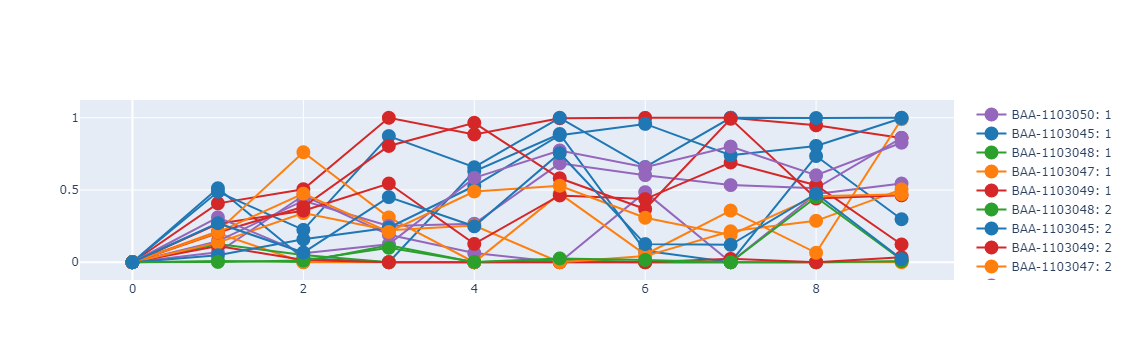

In [114]:
patch_pref_epoch_session.show()

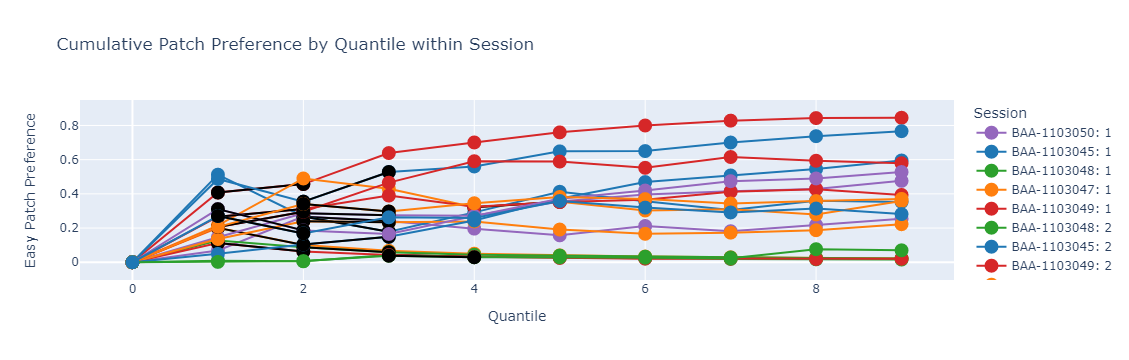

In [133]:
cum_patch_pref_epoch_session = go.Figure()
sesh_subj_counter = DotMap(
    {
        "BAA-1103045": 0,
        "BAA-1103047": 0,
        "BAA-1103048": 0,
        "BAA-1103049": 0,
        "BAA-1103050": 0,
    }
)
for i in df.index:
    uid = df["id"][i]
    y = df["easy_pref_epoch_cum"][i]
    sesh_subj_counter[uid] += 1
    cum_patch_pref_epoch_session.add_trace(
        go.Scatter(
            y=y,
            name=f"{uid}: {sesh_subj_counter[uid]}",
            mode="lines+markers",
            marker={"size": mrkr_sz},
            line=dict(color=color_dict[uid]),
        )
    )
    zidx = int(df["epoch_thresh_change_idx"][i])
    cum_patch_pref_epoch_session.add_trace(
        go.Scatter(
            x=np.array((zidx, zidx + 1)),
            y=y[zidx : zidx + 2],
            mode="lines+markers",
            marker={"size": mrkr_sz},
            line=dict(color="black"),
            name=f"{uid}: {sesh_subj_counter[uid]}: thresh change",
        )
    )
cum_patch_pref_epoch_session.update_layout(
    title="Cumulative Patch Preference by Quantile within Session",
    xaxis_title="Quantile",
    yaxis_title="Easy Patch Preference",
    legend_title="Session",
)
cum_patch_pref_epoch_session.show()

In [131]:
np.array((zidx, zidx + 1))

array([1, 2])

In [124]:
zidx

2.0

In [ ]:
import dash
from dash import Dash, dash_table, dcc, html

bg_col = "#050505"
txt_col = "#f2f2f2"
plt_bg_col = "#0d0d0d"
tab_bg_col = "#003399"
tab_txt_col = "#f2f2f2"
table_max_height = "400px"
table_min_width = "1200px"
mrkr_sz = 14
color_dict = {
    "BAA-1103045": "rgb(31, 119, 180)",
    "BAA-1103047": "rgb(255, 127, 14)",
    "BAA-1103048": "rgb(44, 160, 44)",
    "BAA-1103049": "rgb(214, 39, 40)",
    "BAA-1103050": "rgb(148, 103, 189)",
}
# Set all relevant app.layout children names (for future color theme updates)
fig_names = [
    "weight_enter_session",
    "weight_diff_session",
    "weight_enter_subject",
    "weight_diff_subject",
    "duration_session",
    "post_thresh_dur_session",
    "pre_sampling_both_p_dur_session",
    "duration_subject",
    "post_thresh_dur_subject",
    "pre_sampling_both_p_dur_subject",
    "hard_patch_session",
    "hard_patch_subject",
    "wheel_session_abs",
    "wheel_session_norm",
    "wheel_subject_abs",
    "wheel_subject_norm",
    "pellet_session_abs",
    "pellet_session_norm",
    "pellet_subject_abs",
    "pellet_subject_norm",
    "prob_pels_session",
    "prob_pels_subject",
]
tab_names = []

In [ ]:


data_table = dash_table.DataTable(
    id="data_table",
    data=df.to_dict("records"),
    columns=[{"name": i, "id": i} for i in df.columns],
    style_table={
        "overflowX": "auto",
        "overflowY": "auto",
        "maxHeight": table_max_height,
        "minWidth": table_min_width,
    },
    fixed_columns={"headers": True, "data": 2},
    fixed_rows={"headers": True},
    style_header={"fontWeight": "bold", "backgroundColor": plt_bg_col},
    style_cell={
        "backgroundColor": plt_bg_col,
        "color": txt_col,
        "textAlign": "left",
        "whiteSpace": "normal",
        "height": "auto",
        "minWidth": 60,
    },
)

In [ ]:
display(data_table)

In [ ]:
import dash

In [ ]:
dash

In [ ]:
dash.dash

In [ ]:
from dash.dependencies import Input, Output, State, ClientsideFunction


In [ ]:
import seaborn as sns


In [ ]:
clear dash

In [ ]:
s = list(sessions.itertuples())[-1]

In [ ]:
s

In [ ]:
    root = str(roots[0]) if np.any([s.id.endswith(sid) for sid in in_b2_210]) else str(roots[1])  # get root for current session
    harp_reader = reader.Harp(pattern="Patch1_35", columns=["TriggerPellet"])
    new_pellet_trig_bitmask = api.load(root, harp_reader, start=s.enter, end=s.exit).iloc[0, 0]
    new_pellet_trig_reader_p1 = reader.BitmaskEvent("Patch1_35", new_pellet_trig_bitmask, "TriggerPellet")
    new_pellet_trig_reader_p2 = reader.BitmaskEvent("Patch2_35", new_pellet_trig_bitmask, "TriggerPellet")
    p1 = api.load(root, new_pellet_trig_reader_p1, start=s.enter, end=s.exit)
    p2 = api.load(root, new_pellet_trig_reader_p2, start=s.enter, end=s.exit)